# Importing Necessary Libraries

In [29]:
#!pip uninstall -y numpy catboost
#!pip install numpy==1.26.4 catboost==1.2.7 --force-reinstall

# Required libraries
import os
import gc
import sys
import time
import datetime
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from scipy import stats, sparse
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
from sklearn.linear_model import Ridge, RidgeCV, LogisticRegression, BayesianRidge
from sklearn.metrics import mean_squared_error, log_loss

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier

# Settings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 100)

# Reducing Memory Usage
Large datasets that require high Memory usage

In [30]:
def reduce_mem_usage(df, verbose=True):
    """Downcasts numeric columns to reduce memory usage."""
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2

    for col in df.columns:
        col_type = df[col].dtypes

        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()

            if np.issubdtype(col_type, np.integer):
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)

    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'Mem. usage decreased to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Data Import

In [31]:
# Load and optimize datasets
BASE_PATH = r'data/'

new_merchant_transactions = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'new_merchant_transactions.csv'), parse_dates=['purchase_date'])
)

historical_transactions = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'historical_transactions.csv'), parse_dates=['purchase_date'])
)

train = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'train.csv'), parse_dates=["first_active_month"])
)

test = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'test.csv'), parse_dates=["first_active_month"])
)

merchants = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'merchants.csv'))
)

# Create Binary Target Class
train['target_class'] = train['target'].apply(lambda x: 1 if x >= 0 else 2)

Mem. usage decreased to 121.69 Mb (42.0% reduction)
Mem. usage decreased to 1804.64 Mb (42.0% reduction)
Mem. usage decreased to 4.43 Mb (52.1% reduction)
Mem. usage decreased to 2.24 Mb (52.5% reduction)
Mem. usage decreased to 32.24 Mb (42.6% reduction)


# 2. Exploratory Data Analysis

In [32]:
pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "Rows": [train.shape[0], test.shape[0]],
    "Columns": [train.shape[1], test.shape[1]]
})

,Dataset,Rows,Columns
0,Train,201917,7
1,Test,123623,5


In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  201917 non-null  datetime64[ns]
 1   card_id             201917 non-null  object        
 2   feature_1           201917 non-null  int8          
 3   feature_2           201917 non-null  int8          
 4   feature_3           201917 non-null  int8          
 5   target              201917 non-null  float32       
 6   target_class        201917 non-null  int64         
dtypes: datetime64[ns](1), float32(1), int64(1), int8(3), object(1)
memory usage: 6.0+ MB


In [34]:
train.describe()

,first_active_month,feature_1,feature_2,feature_3,target,target_class
count,201917,201917.000000,201917.000000,201917.000000,201917.000000,201917.000000
mean,2017-01-15 00:30:16.001624320,3.105311,1.745410,0.565569,-0.393636,1.508516
min,2011-11-01 00:00:00,1.000000,1.000000,0.000000,-33.219280,1.000000
25%,2016-10-01 00:00:00,2.000000,1.000000,0.000000,-0.883110,1.000000
50%,2017-04-01 00:00:00,3.000000,2.000000,1.000000,-0.023437,2.000000
75%,2017-09-01 00:00:00,4.000000,2.000000,1.000000,0.765453,2.000000
max,2018-02-01 00:00:00,5.000000,3.000000,1.000000,17.965069,2.000000
std,NaN,1.186160,0.751362,0.495683,3.850227,0.499929


In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123623 entries, 0 to 123622
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   first_active_month  123622 non-null  datetime64[ns]
 1   card_id             123623 non-null  object        
 2   feature_1           123623 non-null  int8          
 3   feature_2           123623 non-null  int8          
 4   feature_3           123623 non-null  int8          
dtypes: datetime64[ns](1), int8(3), object(1)
memory usage: 2.2+ MB


In [36]:
test.describe()

,first_active_month,feature_1,feature_2,feature_3
count,123622,123623.00000,123623.000000,123623.000000
mean,2017-01-15 21:11:17.762857728,3.10926,1.741796,0.564377
min,2011-11-01 00:00:00,1.00000,1.000000,0.000000
25%,2016-10-01 00:00:00,2.00000,1.000000,0.000000
50%,2017-04-01 00:00:00,3.00000,2.000000,1.000000
75%,2017-09-01 00:00:00,4.00000,2.000000,1.000000
max,2018-01-01 00:00:00,5.00000,3.000000,1.000000
std,NaN,1.18911,0.749195,0.495840


In [37]:
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
target_class          0
dtype: int64

In [38]:
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [39]:
print("Duplicate cards in train data:",train.duplicated(subset=["card_id"]).sum())
print("Duplicate cards in test data:",test.duplicated(subset=["card_id"]).sum())

Duplicate cards in train data: 0
Duplicate cards in test data: 0


In [40]:
print("Checking if card id's of test present in train data:",train.card_id.isin(test.card_id).sum())
print("Checking if card id's of train present in test data:",test.card_id.isin(train.card_id).sum())

Checking if card id's of test present in train data: 0
Checking if card id's of train present in test data: 0


**Analysiss**:

1. Here the train and test data looks equally distributed as there are similarity in mean,std,min/max and quntile values.It seems that while spliting data they have used stratified sampling.
2. One null value present in "first_active_month" column of test data which we can impute with mean or mode.For train we dont find any null values.
3. These datasets have no duplication that needs to be addressed.

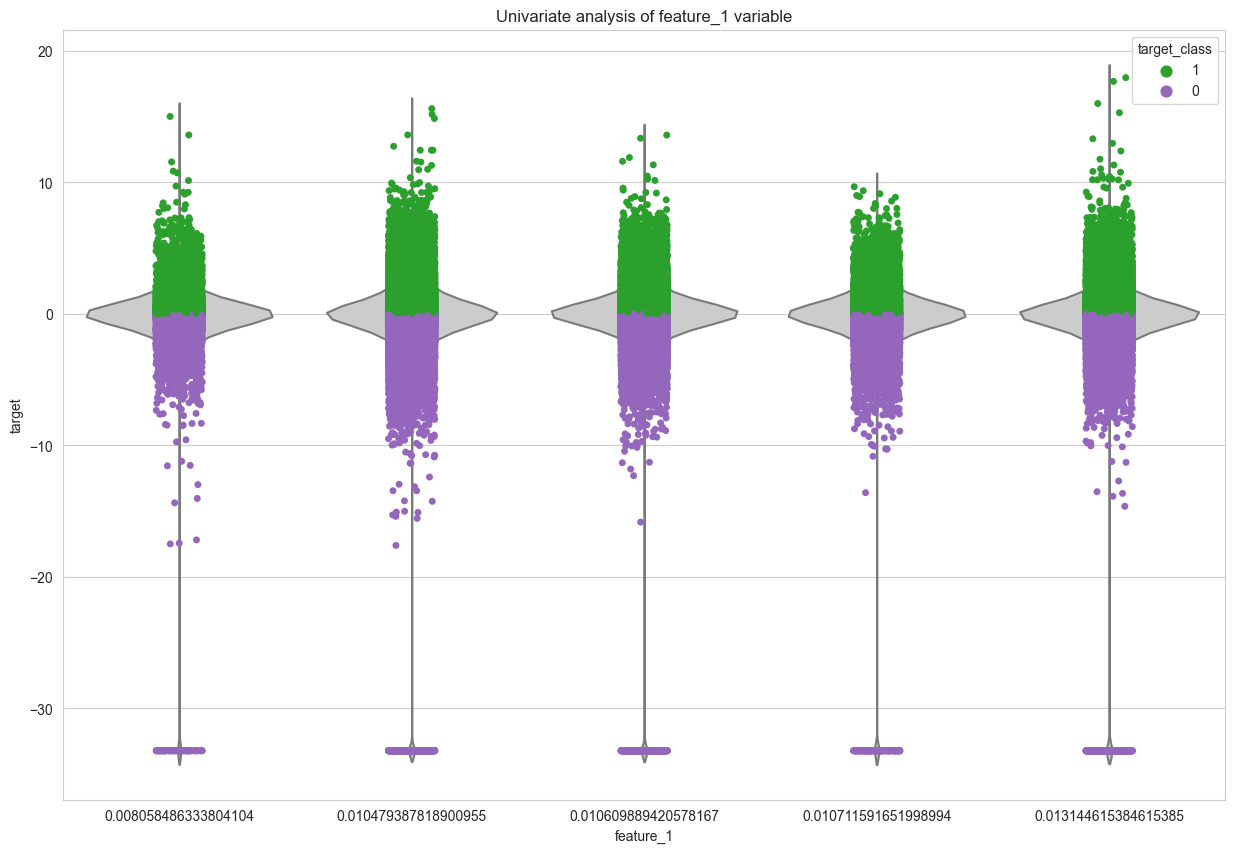

In [121]:
plt.figure(figsize=(15, 10))
sns.violinplot(x="feature_1", y="target", data=train, color=".8")
train['target_class_binary'] = train['target_class'].map({1: 0, 2: 1})


# Plot with target_class_binary (0 = blue, 1 = red)
ax = sns.stripplot(
    x="feature_1", 
    y="target", 
    hue="target_class_binary", 
    data=train, 
    palette = {1: "#9467bd", 0: "#2ca02c"}
)

plt.title("Univariate analysis of feature_1 variable")

# Force legend to use your desired labels
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ["1", "0"], title="target_class")

plt.show()


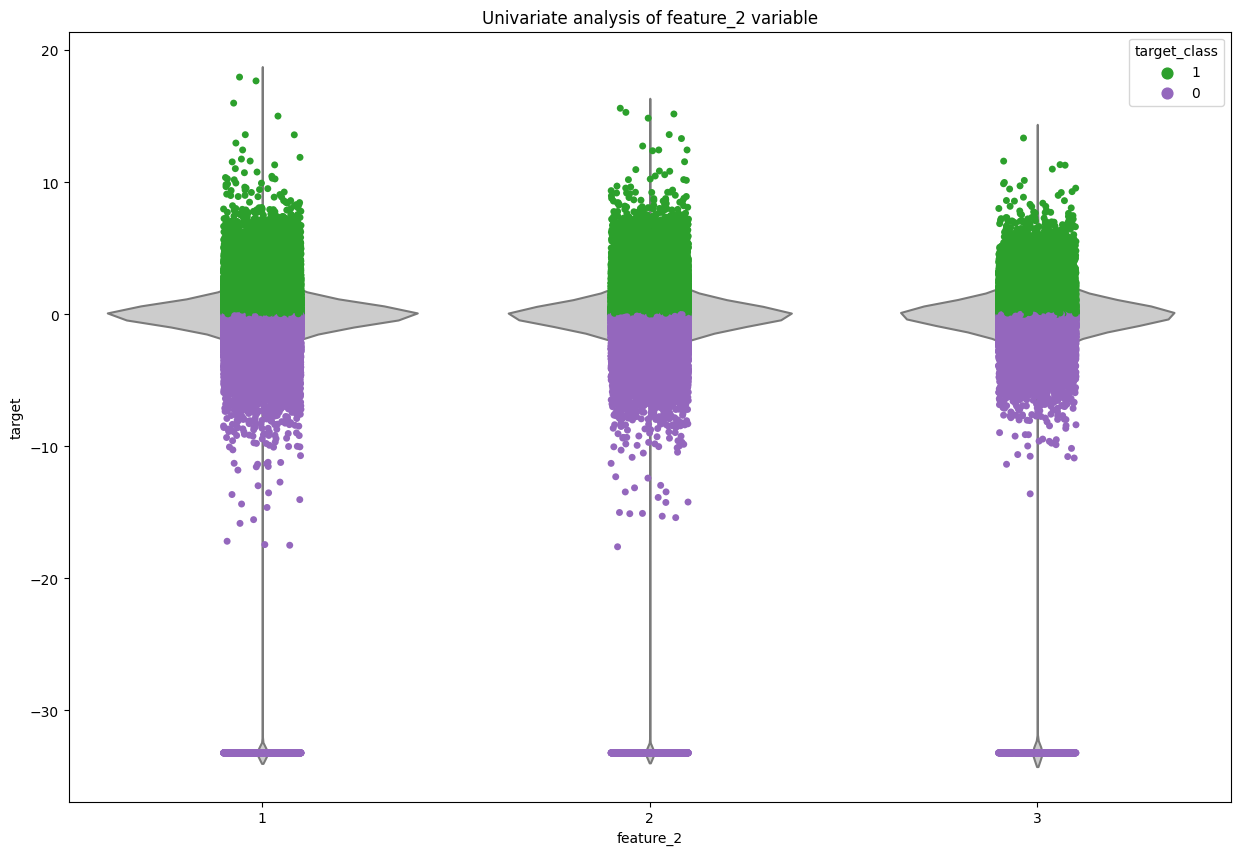

In [44]:
# Step 1: Ensure target_class_binary exists (1 → 0, 2 → 1)
train['target_class_binary'] = train['target_class'].map({1: 0, 2: 1})

# Step 2: Plot
plt.figure(figsize=(15, 10))
sns.violinplot(x="feature_2", y="target", data=train, color=".8")

# Plot with binary hue and fixed colors
ax = sns.stripplot(
    x="feature_2", 
    y="target", 
    hue="target_class_binary", 
    data=train, 
    palette = {1: "#9467bd", 0: "#2ca02c"}
)

# Step 3: Fix the legend
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ["1", "0"], title="target_class")

# Step 4: Title & show
plt.title("Univariate analysis of feature_2 variable")
plt.show()


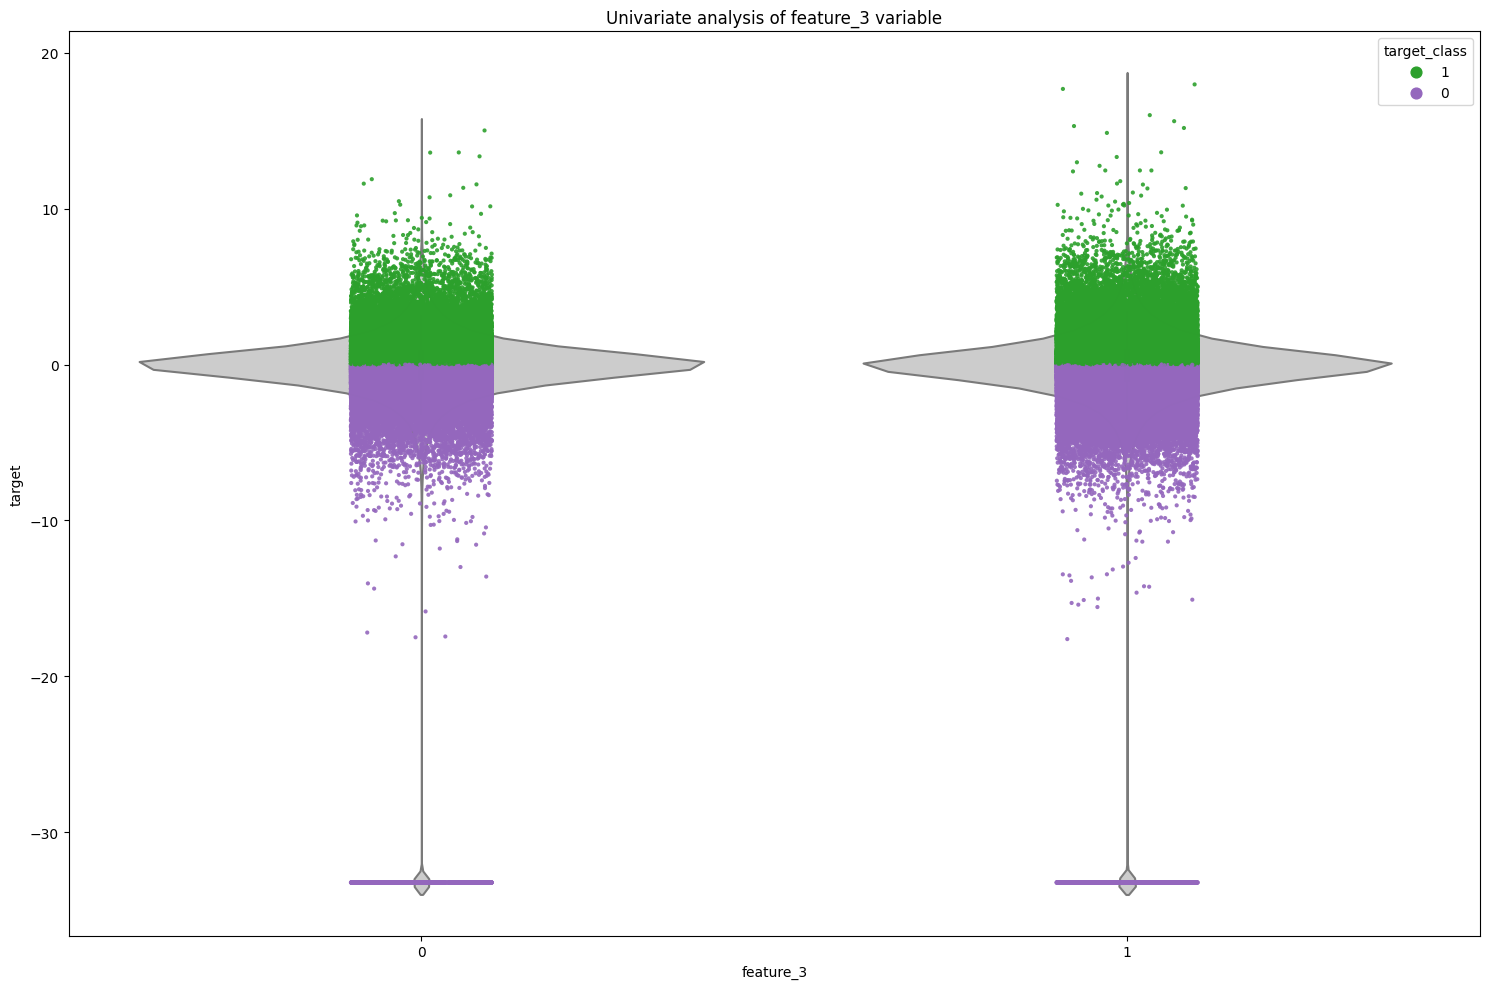

In [49]:
# Make sure binary column exists
train['target_class_binary'] = train['target_class'].map({1: 0, 2: 1})

# Create violin + strip plot
plt.figure(figsize=(15, 10))
sns.violinplot(x="feature_3", y="target", data=train, color=".8")

# Overlay with binary hue and clear colors
ax = sns.stripplot(
    x="feature_3", 
    y="target", 
    hue="target_class_binary", 
    data=train, 
    palette = {1: "#9467bd", 0: "#2ca02c"},
    jitter=True,
    size=3,
    alpha=0.9
)

# Custom legend
handles, _ = ax.get_legend_handles_labels()
plt.legend(handles, ["1", "0"], title="target_class")

plt.title("Univariate analysis of feature_3 variable")
plt.xlabel("feature_3")
plt.ylabel("target")
plt.tight_layout()
plt.show()


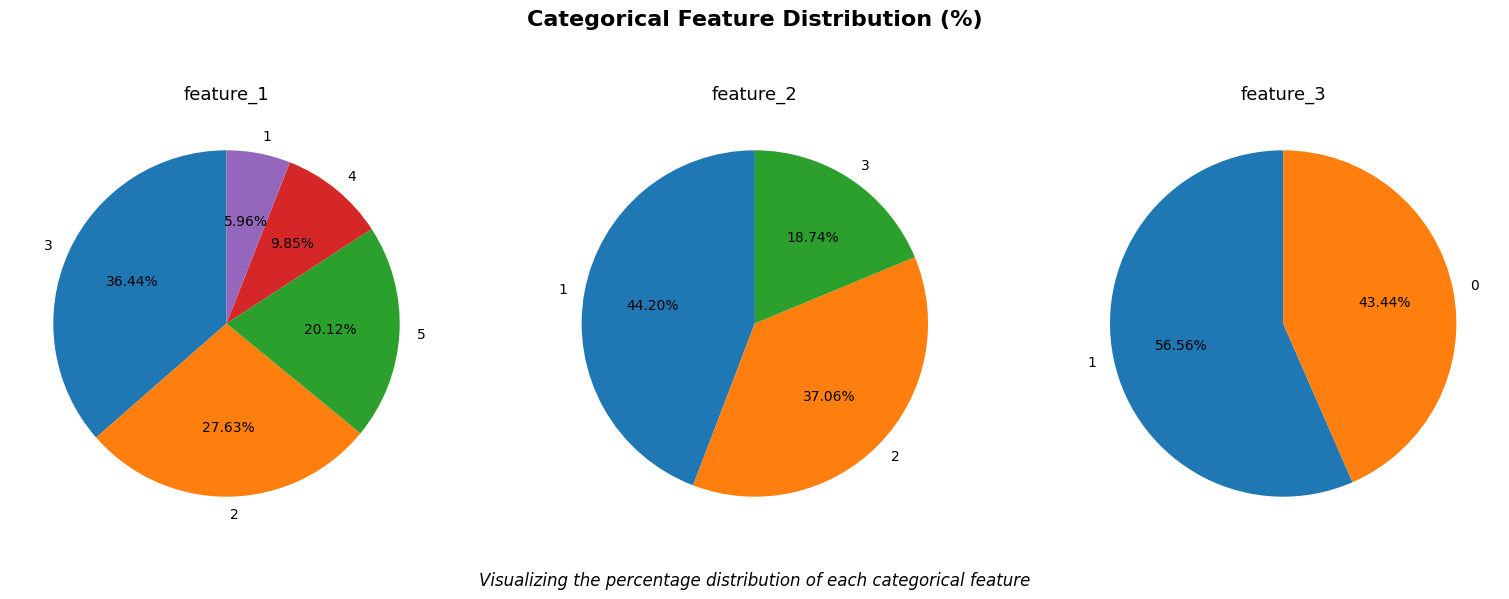

In [48]:
# Define categorical features
categorical_features = ['feature_1', 'feature_2', 'feature_3']

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Categorical Feature Distribution (%)', fontsize=16, fontweight='bold')

# Loop through each categorical feature
for ax, feature in zip(axes, categorical_features):
    # Calculate value percentages
    value_pct = train[feature].value_counts(normalize=True) * 100
    
    # Plot pie chart
    ax.pie(
        value_pct.values,
        labels=value_pct.index.astype(str),
        autopct='%.2f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    ax.set_title(feature, fontsize=13)

# Add caption below the plots
plt.figtext(0.5, 0.02, 'Visualizing the percentage distribution of each categorical feature', 
            ha='center', fontsize=12, style='italic')

# Adjust layout
plt.tight_layout(rect=[0, 0.07, 1, 0.90])
plt.show()

**Analysiss**:
1. The categorical features feature_1, feature_2, and feature_3 appear to contribute similarly to loyalty score prediction, as they show a comparable distribution. Notably, each feature contains a few data points below -30, which may not be outliers and could have a meaningful influence on the model's evaluation.
2. The feature_1 column contains 5 categories, feature_2 has 3 categories, and feature_3 consists of 2 categories. Since these are categorical variables, they should be one-hot encoded before model training. The pie charts above illustrate the percentage distribution of each category within these features.

In [50]:
# Display activation date range
print(f"🟦 Train card activation dates range from {train.first_active_month.min().date()} to {train.first_active_month.max().date()}")
print(f"🟨 Test card activation dates range from {test.first_active_month.min().date()} to {test.first_active_month.max().date()}")

# Optional: Show distribution of activation dates in training set
activation_counts = train.first_active_month.value_counts().sort_index()
print("\n📊 Activation Date Distribution in Train Set:")
print(activation_counts)

🟦 Train card activation dates range from 2011-11-01 to 2018-02-01
🟨 Test card activation dates range from 2011-11-01 to 2018-01-01

📊 Activation Date Distribution in Train Set:
first_active_month
2011-11-01        8
2011-12-01        2
2012-02-01        7
2012-03-01       10
2012-04-01       18
              ...  
2017-10-01    13695
2017-11-01    12930
2017-12-01    10170
2018-01-01       34
2018-02-01        1
Name: count, Length: 75, dtype: int64


**Analysiss**:

The card activation dates span a 7-year period, ranging from 2011 to 2018.

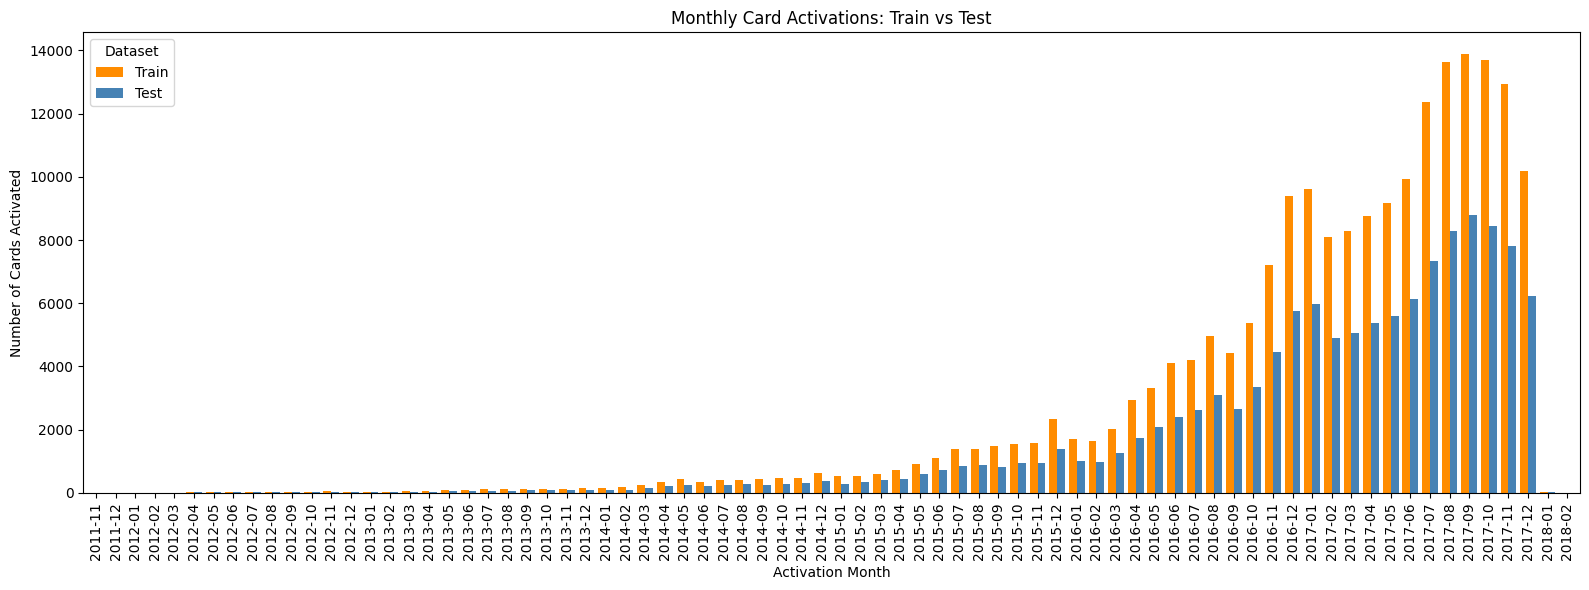

In [51]:
# Convert to Year-Month for grouping
train['year_month'] = train['first_active_month'].dt.to_period('M')
test['year_month'] = test['first_active_month'].dt.to_period('M')

# Count by month
train_monthly = train['year_month'].value_counts().sort_index()
test_monthly = test['year_month'].value_counts().sort_index()

# Combine into a DataFrame
monthly_df = pd.DataFrame({
    'Train': train_monthly,
    'Test': test_monthly
}).fillna(0)

# Plot as grouped bar chart
monthly_df.plot(kind='bar', figsize=(16, 6), width=0.8, color=['darkorange', 'steelblue'])

plt.title('Monthly Card Activations: Train vs Test')
plt.xlabel('Activation Month')
plt.ylabel('Number of Cards Activated')
plt.xticks(rotation=90)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

LinAlgError: The data appears to lie in a lower-dimensional subspace of the space in which it is expressed. This has resulted in a singular data covariance matrix, which cannot be treated using the algorithms implemented in `gaussian_kde`. Consider performing principle component analysis / dimensionality reduction and using `gaussian_kde` with the transformed data.

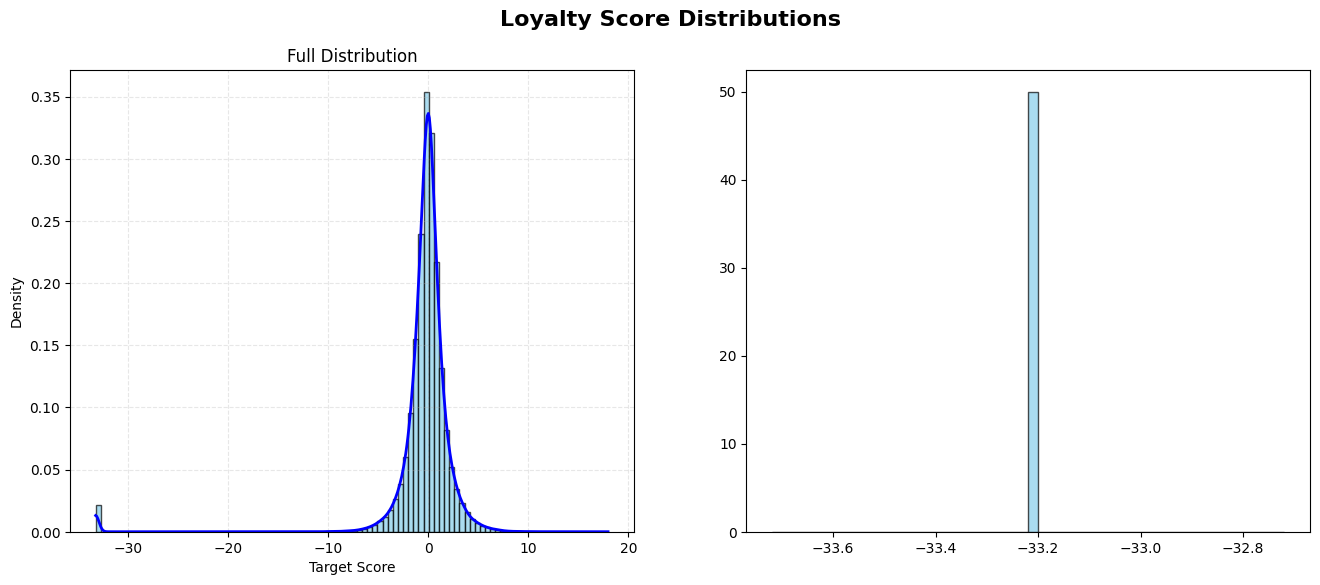

In [52]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import numpy as np

# Prepare data
target_values = train['target'].dropna().values
filtered_target = train['target'][train['target'] < -20].dropna().values

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle("Loyalty Score Distributions", fontsize=16, fontweight='bold')

# --- Plot 1: Full Target Distribution ---
axes[0].hist(target_values, bins=100, color='skyblue', alpha=0.7, edgecolor='black', density=True)
kde_all = gaussian_kde(target_values)
x_vals_all = np.linspace(min(target_values), max(target_values), 500)
axes[0].plot(x_vals_all, kde_all(x_vals_all), color='blue', linewidth=2)

axes[0].set_title("Full Distribution")
axes[0].set_xlabel("Target Score")
axes[0].set_ylabel("Density")
axes[0].grid(True, linestyle="--", alpha=0.3)

# --- Plot 2: Filtered Target < -20 ---
axes[1].hist(filtered_target, bins=50, color='skyblue', alpha=0.7, edgecolor='black', density=True)
kde_filtered = gaussian_kde(filtered_target)
x_vals_filtered = np.linspace(min(filtered_target), max(filtered_target), 500)
axes[1].plot(x_vals_filtered, kde_filtered(x_vals_filtered), color='blue', linewidth=2)

axes[1].set_title("Distribution (target < -20)")
axes[1].set_xlabel("Target Score")
axes[1].set_ylabel("Density")
axes[1].grid(True, linestyle="--", alpha=0.3)

# Final layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
# Count data points based on threshold
below_neg_30 = (train['target'] < -30).sum()
above_or_equal_neg_30 = (train['target'] >= -30).sum()

# Display results
print(f"Loyalty scores below -30: {below_neg_30}")
print(f"Loyalty scores ≥ -30: {above_or_equal_neg_30}")

In [ ]:
# Q-Q plot 
plt.figure(figsize=(8, 6))
stats.probplot(train['target'], dist="norm", plot=plt)

plt.title("Q-Q Plot of Loyalty Scores", fontsize=14)
plt.xlabel("Theoretical Quantiles", fontsize=12)
plt.ylabel("Sample Quantiles", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

**Analysiss**:
1. The Q-Q plot indicates that the target variable does not follow a perfect Normal (Gaussian) distribution. However, the majority of the data points fall within the range of -1 to +1, with only a few points deviating significantly from this central region.
2. Approximately 98% of the loyalty scores lie between -1 and +1, and 99% fall within the range of -10 to +10. Notably, around 1% of the data points (2,207 instances) have loyalty scores below -30. These extreme values appear to be outliers.
3. While these points may influence the distribution, further analysis is required before deciding to remove them. Given that the evaluation metric is Root Mean Squared Error (RMSE), which is sensitive to large deviations, removing these outliers could have a significant impact on model performance. Therefore, it is essential to experiment with both scenarios—with and without the extreme values—to determine the optimal approach.

In [ ]:
merchants.head()

In [ ]:
print("New merchant purchase dates lie between:", new_merchant_transactions.purchase_date.min(), "and", new_merchant_transactions.purchase_date.max())
print("Historical transaction purchase dates lie between:", historical_transactions.purchase_date.min(), "and", historical_transactions.purchase_date.max())


In [ ]:
# Identify duplicate merchant IDs
duplicate_merchants = merchants['merchant_id'].value_counts()
duplicate_merchants = duplicate_merchants[duplicate_merchants > 1]

# Output results
print("Duplicate Merchant IDs (with counts > 1):")
print(duplicate_merchants.to_string())

print(f"\nTotal number of duplicate merchant IDs: {duplicate_merchants.shape[0]}")

In [ ]:
# Calculate missing values and their percentage
null_counts = merchants.isnull().sum()
null_percentages = 100 * null_counts / merchants.shape[0]

# Combine into a DataFrame
null_info_df = pd.DataFrame({
    "Missing Values": null_counts,
    "Missing (%)": null_percentages.round(2)
})

# Filter and sort columns with missing values
null_info_df = null_info_df[null_info_df["Missing Values"] > 0].sort_values("Missing (%)", ascending=False)

# Display the result
null_info_df

In [ ]:
import matplotlib.pyplot as plt

# Re-ordered columns for visual coherence
categorical_columns = [
    'most_recent_purchases_range',
    'most_recent_sales_range',
    'active_months_lag12',
    'active_months_lag6',
    'active_months_lag3'
]

# Set up subplots in a (3, 2) layout
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
fig.suptitle("Categorical Attribute Distributions (Merchants)", fontsize=16, fontweight='bold')

# Define orange shades
orange_shade = '#FFA500'  # standard orange

# Plot each column
for ax, col in zip(axes.flat, categorical_columns):
    value_counts = merchants[col].value_counts().sort_index()
    bars = ax.bar(
        value_counts.index.astype(str), 
        value_counts.values, 
        color=orange_shade, 
        edgecolor='black'
    )

    # Annotate bars with value counts
    for bar in bars:
        height = bar.get_height()
        offset = max(value_counts.values) * 0.015
        ax.text(bar.get_x() + bar.get_width()/2, height + offset, f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

    ax.set_title(col.replace('_', ' ').title(), fontsize=13)
    ax.set_xlabel(col.replace('_', ' ').title(), fontsize=10)
    ax.set_ylabel("Count", fontsize=11)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

# Hide any unused subplots
if len(categorical_columns) < len(axes.flat):
    for i in range(len(categorical_columns), len(axes.flat)):
        fig.delaxes(axes.flat[i])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Analysiss**:
1. There are a total of 41 merchant IDs that appear more than once in the dataset, which can be considered duplicates.
2. These duplicates can be handled by retaining a single record per merchant ID and removing the rest to ensure uniqueness.
3. Several columns contain missing (null) values, which should be addressed through appropriate imputation techniques.
4. From the bar plots, it's evident that the most recent purchase and sales ranges show a significant spread, indicating wide variability.
5. The active month lags (lag 3, 6, and 12) show high values across many merchants, which may indicate consistent activity over time.

In [53]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


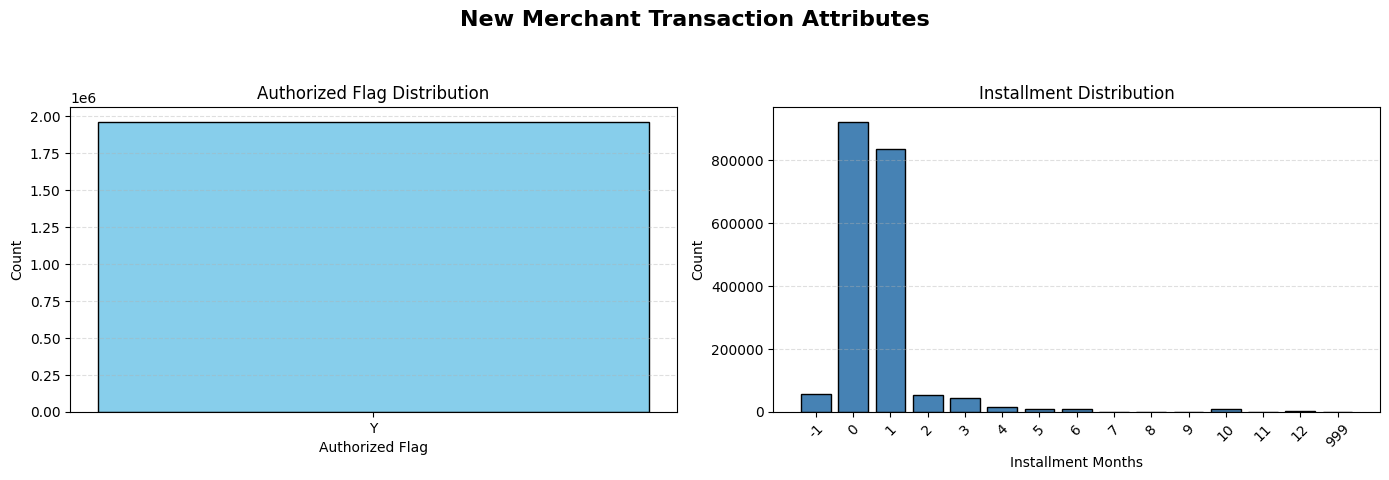

In [54]:
# Prepare data
auth_counts = new_merchant_transactions['authorized_flag'].value_counts()
installment_counts = new_merchant_transactions['installments'].value_counts().sort_index()

# Create side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle("New Merchant Transaction Attributes", fontsize=16, fontweight='bold')

# Plot 1: Authorized Flag
axes[0].bar(auth_counts.index.astype(str), auth_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title("Authorized Flag Distribution")
axes[0].set_xlabel("Authorized Flag")
axes[0].set_ylabel("Count")
axes[0].grid(axis='y', linestyle='--', alpha=0.4)

# Plot 2: Installments
axes[1].bar(installment_counts.index.astype(str), installment_counts.values, color='steelblue', edgecolor='black')
axes[1].set_title("Installment Distribution")
axes[1].set_xlabel("Installment Months")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [55]:
# Calculate null counts and percentages
null_counts = new_merchant_transactions.isnull().sum()
null_percentages = 100 * null_counts / new_merchant_transactions.shape[0]

# Combine into a DataFrame
null_info_df = pd.DataFrame({
    "Missing Values": null_counts,
    "Missing (%)": null_percentages.round(2)
})

# Filter only columns with missing data and sort
null_info_df = null_info_df[null_info_df["Missing Values"] > 0].sort_values("Missing (%)", ascending=False)

# Display
null_info_df

,Missing Values,Missing (%)
category_2,111745,5.69
category_3,55922,2.85
merchant_id,26216,1.34


In [56]:
from datetime import datetime

# Set reference date
reference_date = datetime(2019, 2, 26)

# Define mappings
authorized_flag_map = {'Y': 1, 'N': 0}
category_1_map = {'Y': 1, 'N': 0}
category_3_map = {'A': 1, 'B': 2, 'C': 3, 'D': 4}
installments_map = {**{i: i for i in range(0, 13)}, -1: 14, 999: 13}

# Apply feature engineering
for df in [historical_transactions, new_merchant_transactions]:
    # Convert to datetime
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])

    # Extract date components
    df['year'] = df['purchase_date'].dt.year
    df['month'] = df['purchase_date'].dt.month
    df['day'] = df['purchase_date'].dt.day
    df['hour'] = df['purchase_date'].dt.hour
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekofyear'] = df['purchase_date'].dt.isocalendar().week
    df['weekend'] = (df['purchase_date'].dt.weekday >= 5).astype(int)

    # Map categorical values
    df['authorized_flag'] = df['authorized_flag'].map(authorized_flag_map)
    df['category_1'] = df['category_1'].map(category_1_map)
    df['category_3'] = df['category_3'].map(category_3_map)
    df['installments'] = df['installments'].map(installments_map)

    # Derived features
    df['month_diff'] = ((reference_date - df['purchase_date']).dt.days // 30) + df['month_lag']
    df['price'] = df['purchase_amount'] / df['installments'].replace(0, np.nan)  # Avoid division by 0

    # Quantile features
    df['purchase_amount_quantiles'] = pd.qcut(df['purchase_amount'], 5, labels=False)
    df['installments_quantiles'] = pd.qcut(df['installments'], 5, labels=False, duplicates='drop')

    # Ratio feature
    df['amount_month_ratio'] = df['purchase_amount'] / (1.0 + df['month_diff'])

# Clean up
gc.collect()


15303

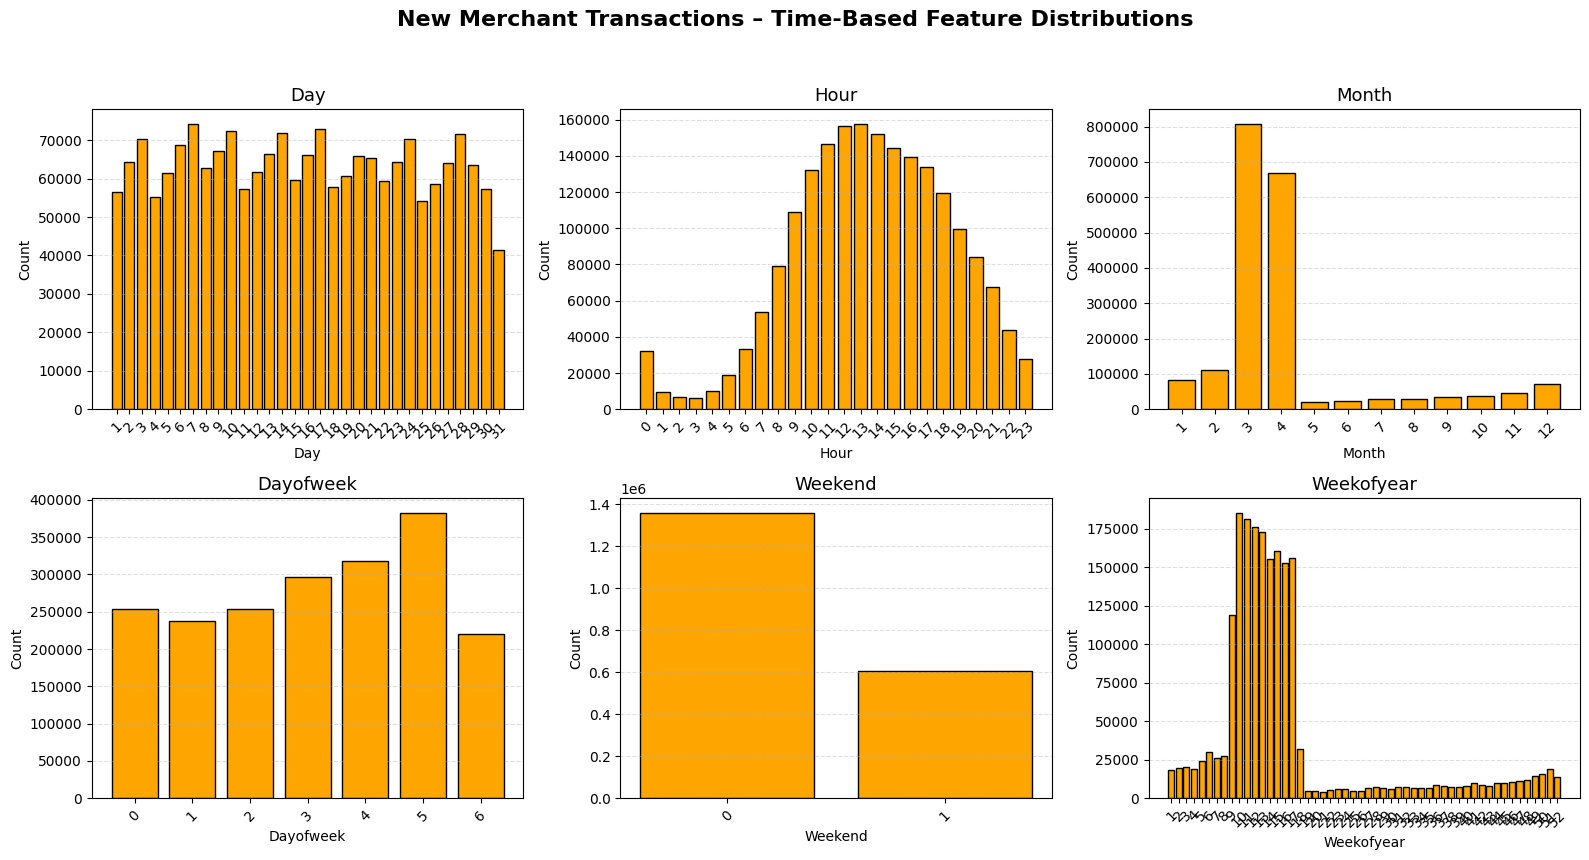

In [57]:
import matplotlib.pyplot as plt

# Time-based features to analyze
time_features = ['day', 'hour', 'month', 'dayofweek', 'weekend', 'weekofyear']

# Set up subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('New Merchant Transactions – Time-Based Feature Distributions', fontsize=16, fontweight='bold')

# Plot each feature
for ax, feature in zip(axes.flat, time_features):
    counts = new_merchant_transactions[feature].value_counts().sort_index()
    ax.bar(counts.index.astype(str), counts.values, color='orange', edgecolor='black')
    ax.set_title(feature.replace('_', ' ').title(), fontsize=13)
    ax.set_xlabel(feature.title())
    ax.set_ylabel("Count")
    ax.tick_params(axis='x', rotation=45)
    ax.grid(axis='y', linestyle='--', alpha=0.4)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Analysis**:
1. The authorized_flag column contains only 'Y' values, indicating that all transactions are authorized. Since this column lacks variability, it likely holds little predictive value and can be removed from the dataset.
2. The majority of purchase amounts fall within the range of 0 to 50, with fewer transactions between 50 and 100. A small number of entries exceed 100, which may be considered outliers.
3. The installments feature is expected to range from 0 to 12 months, but values such as -1 and 999 are present. These may represent erroneous or special-case entries and should be handled appropriately.
4. Three columns contain missing values: category_2, category_3, and merchant_id. These missing entries should be addressed through either imputation or removal, depending on their significance and distribution.
5. Users tend to make more purchases on Saturdays compared to other days of the week. Purchases are lower toward the end of the month, with peaks observed in the months of March and April. Additionally, most purchases occur between 9 AM and 6 PM, indicating higher activity during typical business hours.

In [58]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,year,month,day,hour,dayofweek,weekofyear,weekend,month_diff,price,purchase_amount_quantiles,installments_quantiles,amount_month_ratio
0,1,C_ID_4e6213e9bc,88,0,0,1.0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,25,15,6,25,1,12,NaN,2,0,-0.054102
1,1,C_ID_4e6213e9bc,88,0,0,1.0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,15,12,5,28,1,12,NaN,0,0,-0.056394
2,1,C_ID_4e6213e9bc,88,0,0,1.0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,9,22,2,32,0,12,NaN,1,0,-0.055414
3,1,C_ID_4e6213e9bc,88,0,0,1.0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,2017,9,2,10,5,35,1,13,NaN,0,0,-0.052525
4,1,C_ID_4e6213e9bc,88,0,0,1.0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,2017,3,10,1,4,10,0,12,NaN,1,0,-0.055605


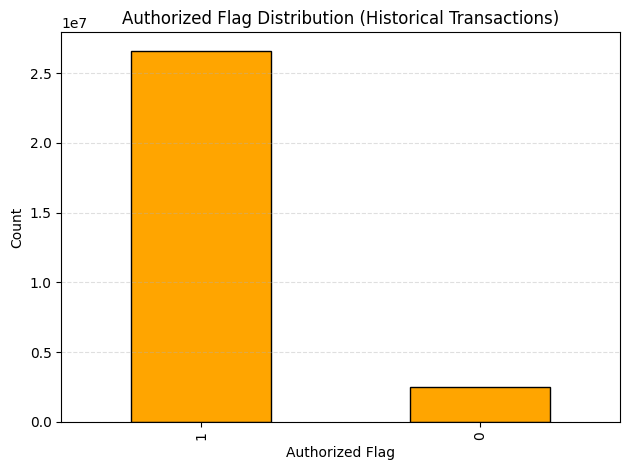

In [59]:
# Step 1: Check if column exists
if 'authorized_flag' in historical_transactions.columns:
    
    # Step 2: Check for non-null values
    non_null_counts = historical_transactions['authorized_flag'].notnull().sum()
    
    if non_null_counts > 0:
        # Plot if valid values exist
        historical_transactions['authorized_flag'].value_counts().plot(kind="bar", color='orange', edgecolor='black')
        plt.title("Authorized Flag Distribution (Historical Transactions)")
        plt.xlabel("Authorized Flag")
        plt.ylabel("Count")
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()
    else:
        print("The 'authorized_flag' column exists but contains only null values.")
else:
    print("The 'authorized_flag' column does not exist in the dataset.")


In [60]:
# Calculate missing values and their percentages
null_counts = historical_transactions.isnull().sum()
null_percentages = 100 * null_counts / historical_transactions.shape[0]

# Combine into a clean DataFrame
null_info_df = pd.DataFrame({
    "Missing Values": null_counts,
    "Missing (%)": null_percentages.round(2)
})

# Filter to show only columns with missing values
null_info_df = null_info_df[null_info_df["Missing Values"] > 0].sort_values("Missing (%)", ascending=False)

# Display the result
null_info_df

,Missing Values,Missing (%)
price,15411747,52.94
category_2,2652864,9.11
category_3,178159,0.61
merchant_id,138481,0.48


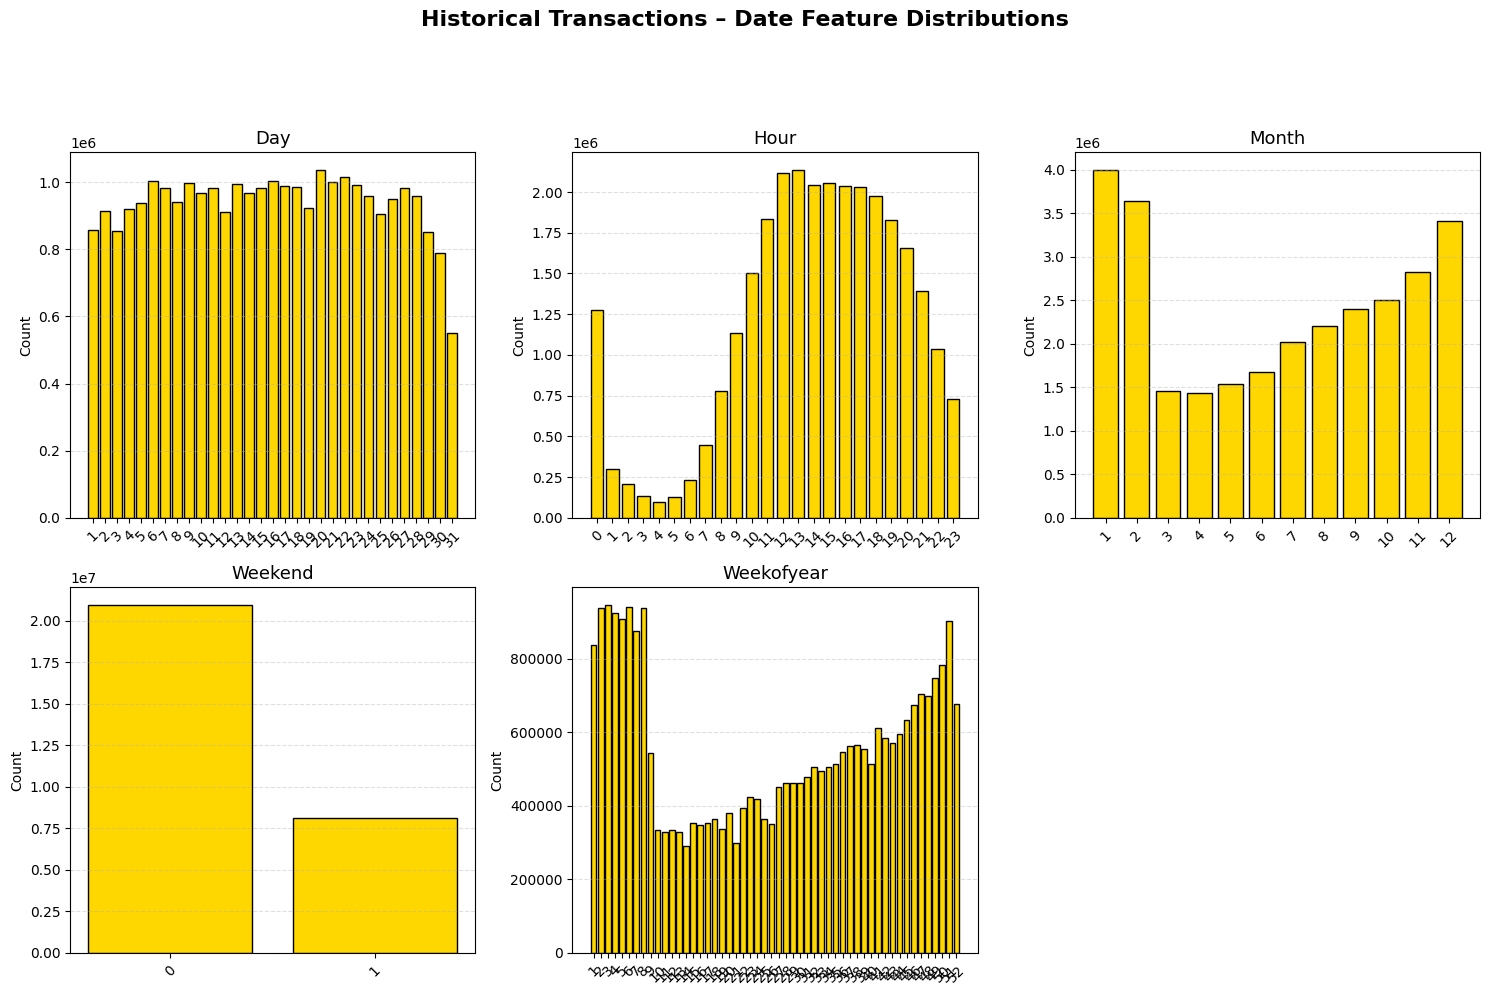

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Time-related columns to analyze
date_cols = ['weekofyear', 'weekday', 'weekend', 'month', 'day', 'hour']

# Filter available date columns
date_cols_sorted = sorted([col for col in historical_transactions.columns if col in date_cols])

# Subplot layout
ncols = 3
nrows = int(np.ceil(len(date_cols_sorted) / ncols))
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))
fig.suptitle('Historical Transactions – Date Feature Distributions', fontsize=16, fontweight='bold', y=1.02)

# Flatten axes
axes = axes.flatten()

# Bar color (yellow theme)
bar_color = '#FFD700'  # Gold

# Plot each column
for idx, col in enumerate(date_cols_sorted):
    vc = historical_transactions[col].value_counts().sort_index()
    axes[idx].bar(vc.index.astype(str), vc.values, color=bar_color, edgecolor='black')
    axes[idx].set_title(col.title(), fontsize=13)
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].set_ylabel("Count")
    axes[idx].grid(axis='y', linestyle='--', alpha=0.4)

# Remove any unused axes
for j in range(len(date_cols_sorted), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


**Analysis**:
1. Unlike the new merchant transaction data, the historical transaction dataset includes unauthorized transactions. Further analysis is needed to determine whether these records should be removed or retained for model training.
2. Similar to the new merchant transactions, the highest number of purchases occurs on Saturdays, indicating consistent consumer behavior across both datasets.
3. In contrast to the new merchant transactions where peak purchase months are March and April, the historical transactions show the highest activity during January, February, and December.



In [62]:
def get_new_columns(name,aggs):
    return [name + '_' + k + '_' + agg for k in aggs.keys() for agg in aggs[k]]

In [63]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var','count']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean','sum','count']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['day'] = ['mean']
aggs['weekofyear'] = ['mean']
aggs['month'] = ['mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']
aggs['installments_quantiles']=['var', 'mean', 'skew']
aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']

for col in ['category_2','category_3']:
    historical_transactions[col+'_mean'] = historical_transactions.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']    
    
new_columns = get_new_columns('hist',aggs)
df_hist_trans_group = historical_transactions.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
train = train.merge(df_hist_trans_group,on='card_id',how='left')
test = test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group
gc.collect()

63

In [64]:
aggs = {}
for col in ['month','hour','weekofyear','dayofweek','year','subsector_id','merchant_id','merchant_category_id']:
    aggs[col] = ['nunique']

aggs['purchase_amount'] = ['sum','max','min','mean','var']
aggs['installments'] = ['sum','max','min','mean','var']
aggs['purchase_date'] = ['max','min']
aggs['month_lag'] = ['max','min','mean','var']
aggs['month_diff'] = ['mean','sum']
aggs['authorized_flag'] = ['sum', 'mean']
aggs['weekend'] = ['sum', 'mean']
aggs['day'] = ['mean']
aggs['weekofyear'] = ['mean']
aggs['month'] = ['mean']
aggs['category_1'] = ['sum', 'mean']
aggs['card_id'] = ['size']
aggs['installments_quantiles']=['var', 'mean', 'skew']
aggs['purchase_amount_quantiles']=['var', 'mean', 'skew']


for col in ['category_2','category_3']:
    new_merchant_transactions[col+'_mean'] = new_merchant_transactions.groupby([col])['purchase_amount'].transform('mean')
    aggs[col+'_mean'] = ['mean']

new_columns = get_new_columns('new',aggs)
df_hist_trans_group = new_merchant_transactions.groupby('card_id').agg(aggs)
df_hist_trans_group.columns = new_columns
df_hist_trans_group.reset_index(drop=False,inplace=True)
train = train.merge(df_hist_trans_group,on='card_id',how='left')
test = test.merge(df_hist_trans_group,on='card_id',how='left')
del df_hist_trans_group;
gc.collect()
     

0

In [67]:
import datetime

for df in [train,test]:
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['dayofweek'] = df['first_active_month'].dt.dayofweek
    df['weekofyear'] = df['first_active_month'].dt.isocalendar().week
    df['month'] = df['first_active_month'].dt.month
    df['elapsed_time'] = (datetime.datetime(2019, 2, 26) - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
    df['card_id_total'] = df['hist_card_id_size']+df['hist_card_id_size']
    df['purchase_amount_total'] = df['hist_purchase_amount_sum']+df['hist_purchase_amount_sum']
    df['days_feature1'] = df['elapsed_time'] * df['feature_1']   

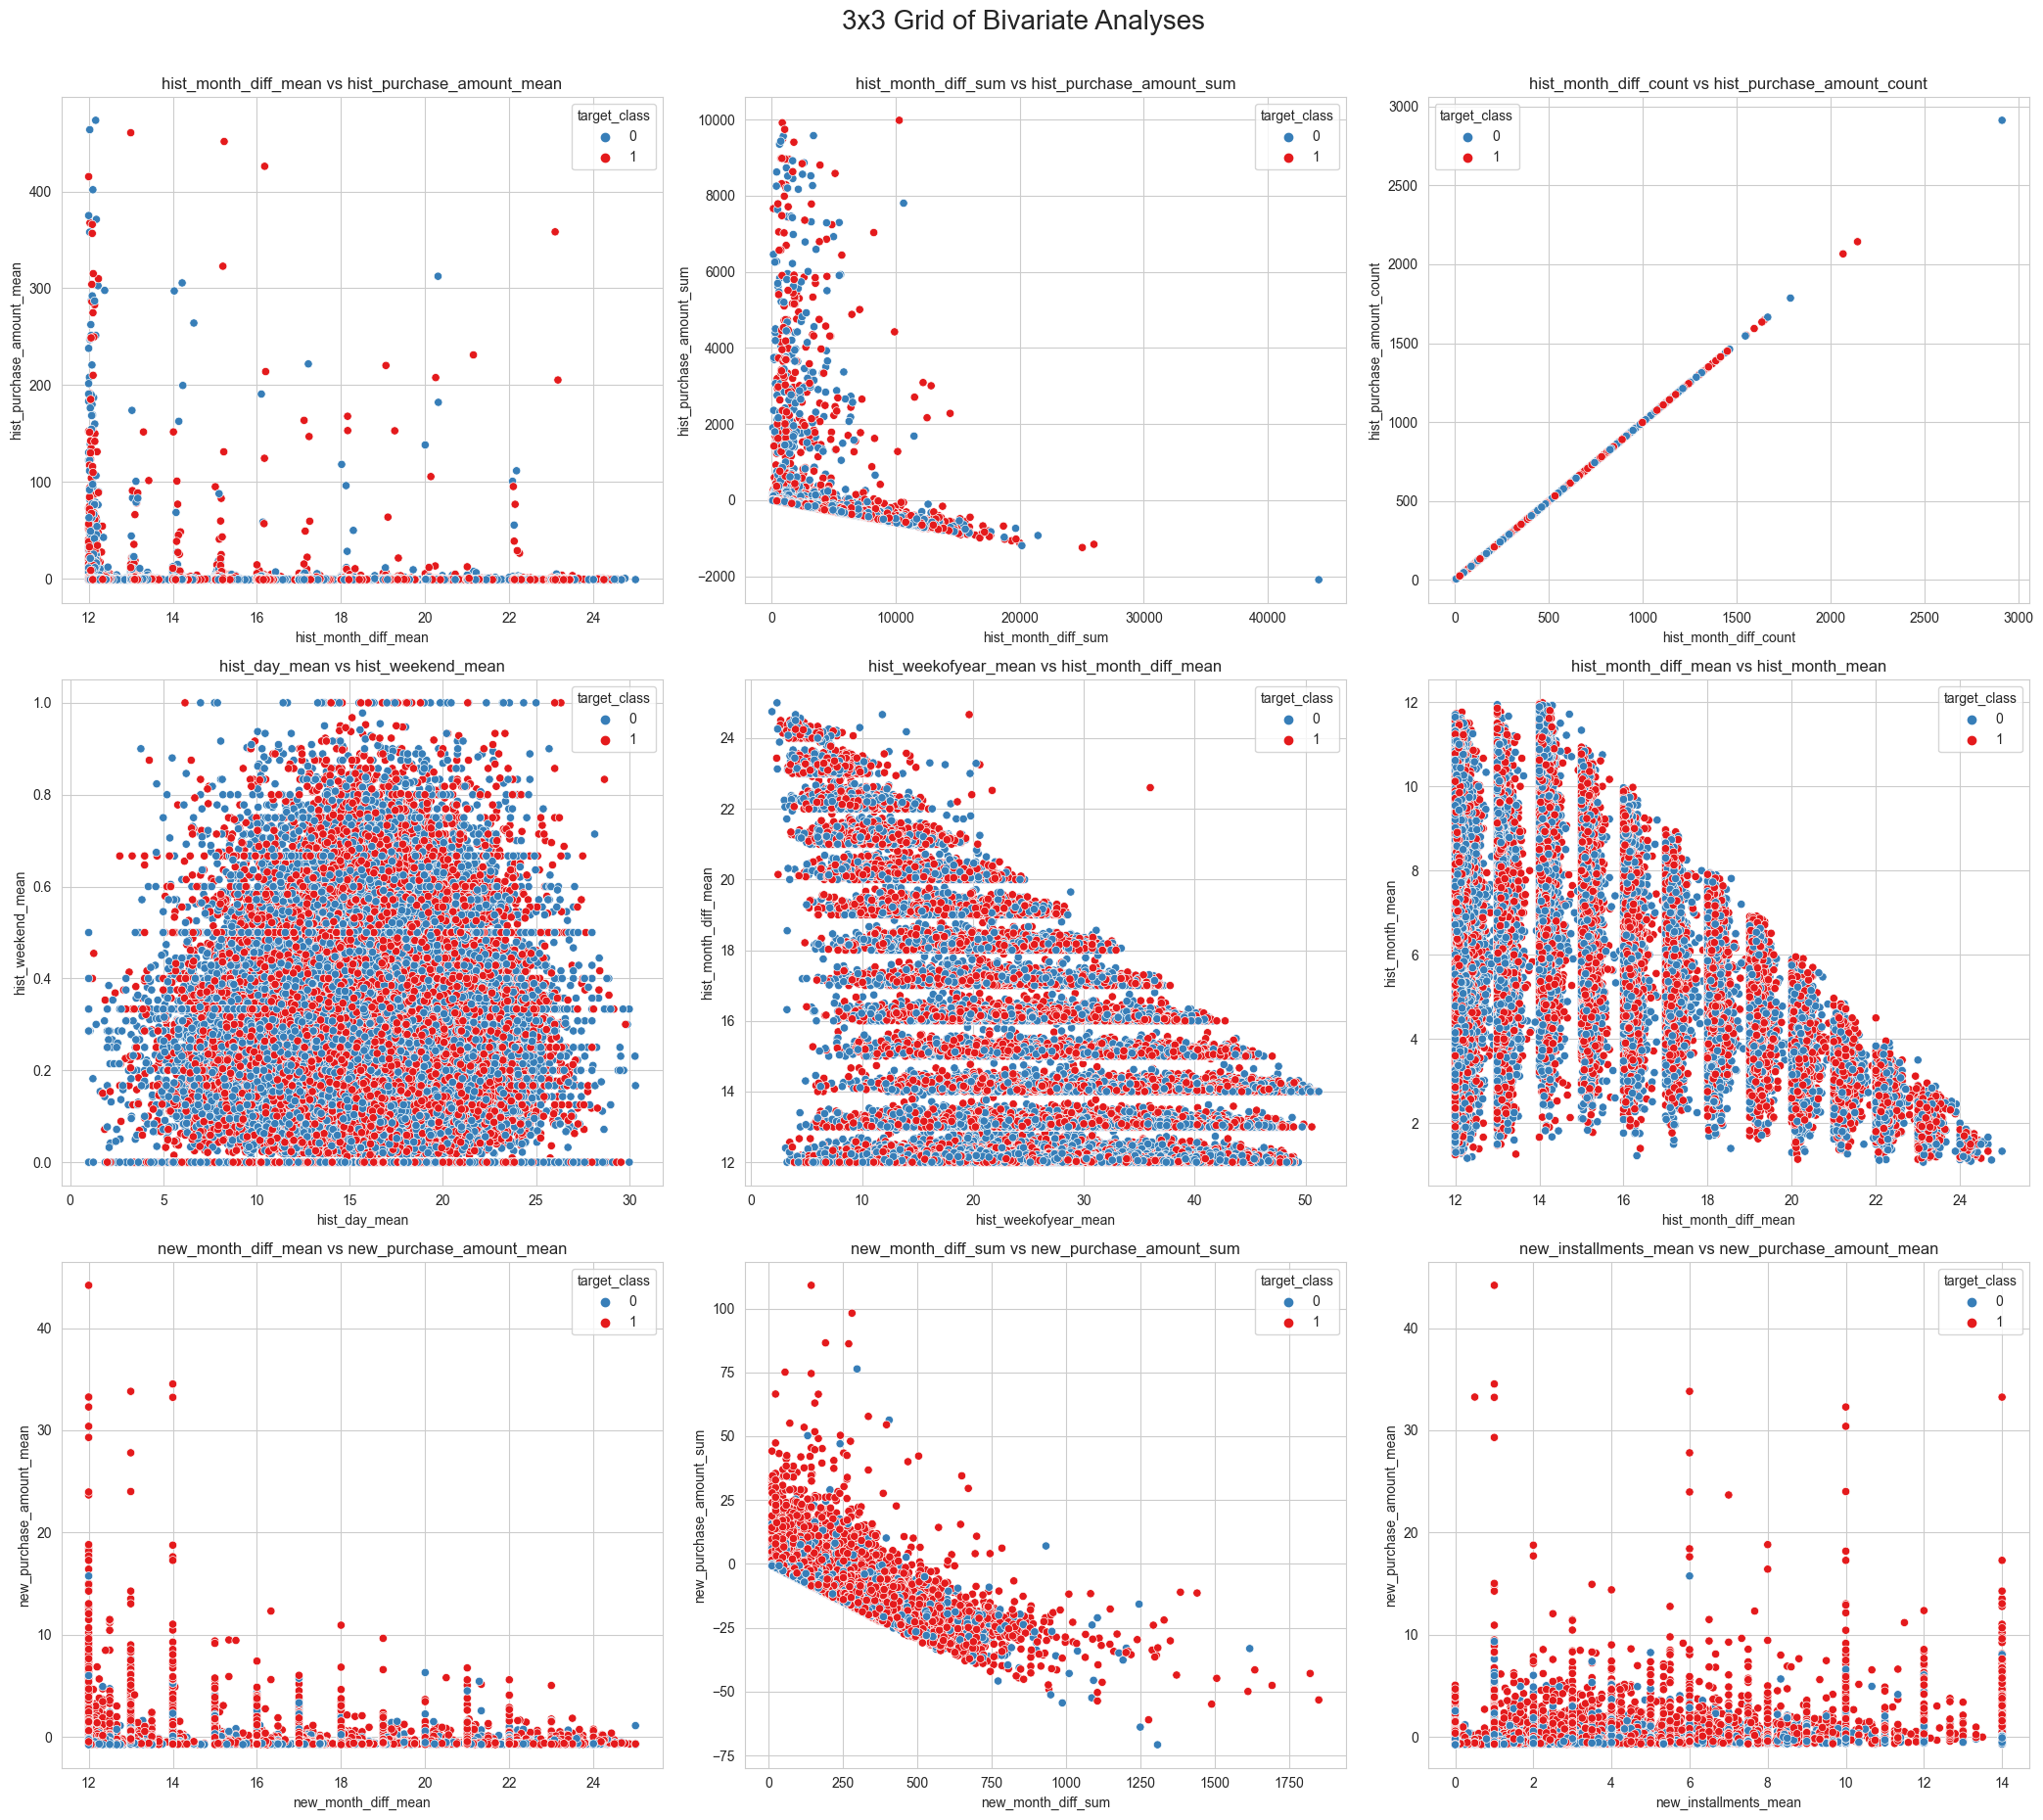

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
custom_palette = {0: "#377eb8", 1: "#e41a1c"}

# === Data Preparation ===
filtered_1 = train[train.hist_purchase_amount_mean < 500].copy()
filtered_1["target_class_binary"] = filtered_1["target_class"].map({1: 0, 2: 1})

filtered_2 = train[train.hist_purchase_amount_sum < 10000].copy()
filtered_2["target_class_binary"] = filtered_2["target_class"].map({1: 0, 2: 1})

filtered_3 = train.copy()
filtered_3["target_class_binary"] = filtered_3["target_class"].map({1: 0, 2: 1})

filtered_4 = train.copy()
filtered_4["target_class_binary"] = filtered_4["target_class"].map({1: 0, 2: 1})

filtered_5 = train[train.hist_purchase_amount_mean < 500000].copy()
filtered_5["target_class_binary"] = filtered_5["target_class"].map({1: 0, 2: 1})

filtered_6 = train.copy()
filtered_6["target_class_binary"] = filtered_6["target_class"].map({1: 0, 2: 1})

filtered_7 = train.copy()
filtered_7["target_class_binary"] = filtered_7["target_class"].map({1: 0, 2: 1})

filtered_8 = train[train.hist_purchase_amount_sum < 10000].copy()
filtered_8["target_class_binary"] = filtered_8["target_class"].map({1: 0, 2: 1})

filtered_9 = train.copy()
filtered_9["target_class_binary"] = filtered_9["target_class"].map({1: 0, 2: 1})

# === Create 3x3 Subplot Grid ===
fig, axes = plt.subplots(3, 3, figsize=(21, 18))

# Row 1
sns.scatterplot(data=filtered_1, x="hist_month_diff_mean", y="hist_purchase_amount_mean",
                hue="target_class_binary", palette=custom_palette, ax=axes[0, 0])
axes[0, 0].set_title("hist_month_diff_mean vs hist_purchase_amount_mean")
axes[0, 0].legend(title="target_class")

sns.scatterplot(data=filtered_2, x="hist_month_diff_sum", y="hist_purchase_amount_sum",
                hue="target_class_binary", palette=custom_palette, ax=axes[0, 1])
axes[0, 1].set_title("hist_month_diff_sum vs hist_purchase_amount_sum")
axes[0, 1].legend(title="target_class")

sns.scatterplot(data=filtered_3, x="hist_month_diff_count", y="hist_purchase_amount_count",
                hue="target_class_binary", palette=custom_palette, ax=axes[0, 2])
axes[0, 2].set_title("hist_month_diff_count vs hist_purchase_amount_count")
axes[0, 2].legend(title="target_class")

# Row 2
sns.scatterplot(data=filtered_4, x="hist_day_mean", y="hist_weekend_mean",
                hue="target_class_binary", palette=custom_palette, ax=axes[1, 0])
axes[1, 0].set_title("hist_day_mean vs hist_weekend_mean")
axes[1, 0].legend(title="target_class")

sns.scatterplot(data=filtered_5, x="hist_weekofyear_mean", y="hist_month_diff_mean",
                hue="target_class_binary", palette=custom_palette, ax=axes[1, 1])
axes[1, 1].set_title("hist_weekofyear_mean vs hist_month_diff_mean")
axes[1, 1].legend(title="target_class")

sns.scatterplot(data=filtered_6, x="hist_month_diff_mean", y="hist_month_mean",
                hue="target_class_binary", palette=custom_palette, ax=axes[1, 2])
axes[1, 2].set_title("hist_month_diff_mean vs hist_month_mean")
axes[1, 2].legend(title="target_class")

# Row 3
sns.scatterplot(data=filtered_7, x="new_month_diff_mean", y="new_purchase_amount_mean",
                hue="target_class_binary", palette=custom_palette, ax=axes[2, 0])
axes[2, 0].set_title("new_month_diff_mean vs new_purchase_amount_mean")
axes[2, 0].legend(title="target_class")

sns.scatterplot(data=filtered_8, x="new_month_diff_sum", y="new_purchase_amount_sum",
                hue="target_class_binary", palette=custom_palette, ax=axes[2, 1])
axes[2, 1].set_title("new_month_diff_sum vs new_purchase_amount_sum")
axes[2, 1].legend(title="target_class")

sns.scatterplot(data=filtered_9, x="new_installments_mean", y="new_purchase_amount_mean",
                hue="target_class_binary", palette=custom_palette, ax=axes[2, 2])
axes[2, 2].set_title("new_installments_mean vs new_purchase_amount_mean")
axes[2, 2].legend(title="target_class")

# Final layout
plt.tight_layout()
plt.suptitle("3x3 Grid of Bivariate Analyses", fontsize=20, y=1.03)
plt.show()


# 3 & 4. Data Preprocessing & Basic Feature Engineering
This script processes transaction datasets by cleaning missing values, engineering time-based features, and preparing the data for modeling

In [92]:
# Load and optimize datasets
BASE_PATH = r'data/'

new_merchant_transactions = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'new_merchant_transactions.csv'), parse_dates=['purchase_date'])
)

historical_transactions = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'historical_transactions.csv'), parse_dates=['purchase_date'])
)

train = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'train.csv'), parse_dates=["first_active_month"])
)

test = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'test.csv'), parse_dates=["first_active_month"])
)

merchants = reduce_mem_usage(
    pd.read_csv(os.path.join(BASE_PATH, 'merchants.csv'))
)

# Create Binary Target Class
train['target_class'] = train['target'].apply(lambda x: 1 if x >= 0 else 2)

Mem. usage decreased to 121.69 Mb (42.0% reduction)
Mem. usage decreased to 1804.64 Mb (42.0% reduction)
Mem. usage decreased to 4.43 Mb (52.1% reduction)
Mem. usage decreased to 2.24 Mb (52.5% reduction)
Mem. usage decreased to 32.24 Mb (42.6% reduction)


In [93]:
## Memory management

# %%time
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                #elif c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    #df[col] = df[col].astype(np.float16)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1%} reduction)'.format(end_mem, (start_mem-end_mem)/start_mem))
    return df



In [ ]:
## Reference: https://medium.com/towards-artificial-intelligence/handling-missing-data-for-advanced-machine-learning-b6eb89050357

def model_imputation(data_frame, non_categorical_clmn, features_nan_value, models):
  '''This function perform model imputation for categorical columns having null values
     with specified algorithm'''
     
  tmp_storage = data_frame[non_categorical_clmn]
  data_frame.drop(non_categorical_clmn, axis=1, inplace=True)
  features_no_nan_values = [c for c in data_frame.columns if c not in features_nan_value]

  for feat in tqdm(features_nan_value):
    print(feat)
    df_null = data_frame[data_frame[feat].isna()]
    df_train = data_frame.dropna()
    clf = models[feat]
    clf.fit(df_train[features_no_nan_values], df_train[feat])     
    data_frame.loc[data_frame[feat].isna(), feat] = clf.predict(df_null[features_no_nan_values])
    data_frame[non_categorical_clmn] = tmp_storage[non_categorical_clmn]  
  del tmp_storage
  return data_frame

In [ ]:
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1'].map({'Y':1, 'N':0})
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].map({'A':1, 'B':2,'C':3})
new_merchant_transactions['authorized_flag'] = new_merchant_transactions['authorized_flag'].map({'Y':1, 'N':0})
historical_transactions['category_1'] = historical_transactions['category_1'].map({'Y':1, 'N':0})
historical_transactions['category_3'] = historical_transactions['category_3'].map({'A':1, 'B':2,'C':3})
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].map({'Y':1, 'N':0})

In [96]:
non_categorical= ['card_id', 'merchant_id', 'purchase_date']
model_transacations = {'category_2':LogisticRegression(),'category_3':LogisticRegression() }

new_merchant_transactions =reduce_mem_usage(model_imputation(data_frame = new_merchant_transactions,
                                           non_categorical_clmn = non_categorical,
                                           features_nan_value =  ['category_2', 'category_3'],
                                           models = model_transacations))

  0%|                                                     | 0/2 [00:00<?, ?it/s]

category_2


 50%|██████████████████████▌                      | 1/2 [01:09<01:09, 69.62s/it]

category_3


100%|█████████████████████████████████████████████| 2/2 [02:01<00:00, 60.59s/it]


Mem. usage decreased to 87.99 Mb (27.7% reduction)


In [97]:
# new_merchant_transactions.to_csv("new_merchant_transactions_model_imputed.csv",index=False)
new_merchant_transactions=reduce_mem_usage(pd.read_csv("data/new_merchant_transactions_model_imputed.csv",parse_dates=['purchase_date']))
gc.collect()

Mem. usage decreased to 87.99 Mb (58.0% reduction)


124540

In [98]:
non_categorical= ['card_id', 'merchant_id', 'purchase_date']
model_transacations = {'category_2':LogisticRegression(),'category_3':LogisticRegression() }

historical_transactions =reduce_mem_usage(model_imputation(data_frame = historical_transactions,
                                          non_categorical_clmn = non_categorical,
                                          features_nan_value =  ['category_2', 'category_3'],
                                          models = model_transacations))


  0%|                                                     | 0/2 [00:00<?, ?it/s]

category_2


 50%|█████████████████████▌                     | 1/2 [33:40<33:40, 2020.80s/it]

category_3


100%|███████████████████████████████████████████| 2/2 [59:05<00:00, 1772.53s/it]


Mem. usage decreased to 1304.89 Mb (27.7% reduction)


In [100]:
# historical_transactions.to_csv("historical_transactions_model_imputed.csv",index=False)
historical_transactions=reduce_mem_usage(pd.read_csv("data/historical_transactions_model_imputed.csv",parse_dates=['purchase_date']))
gc.collect()

Mem. usage decreased to 1304.89 Mb (58.0% reduction)


210

In [101]:
def oneHotEncoding(df, features): 
  '''This function helps created one hot encoded features for given column'''

  for feat in tqdm(features):
    unique_values = df[feat].unique()

    for cat in unique_values:
      df[feat+'={}'.format(cat)] = (df[feat] == cat).astype(int)
     

In [102]:
#Features for one-hot encoding 
categorical_features = ['category_2','category_3','month_lag']

#historical transactions one-hot feature encoding 
oneHotEncoding(historical_transactions, features=categorical_features)

#new merchants transactions one-hot feature encoding
oneHotEncoding(new_merchant_transactions, features=categorical_features)

gc.collect()

100%|█████████████████████████████████████████████| 3/3 [00:00<00:00,  5.60it/s]


0

In [103]:
def transactions_data_conversion():
  '''This function performing some basic data conversion'''
  
  ## reference: https://www.kaggle.com/raddar/towards-de-anonymizing-the-data-some-insights
  new_merchant_transactions['purchase_amount'] = np.round(new_merchant_transactions['purchase_amount'] / 0.00150265118 + 497.06, 2)
  historical_transactions['purchase_amount'] = np.round(historical_transactions['purchase_amount'] / 0.00150265118 + 497.06, 2)

  for df in [historical_transactions,new_merchant_transactions]:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    df['year'] = df['purchase_date'].dt.year
    df['day']=df['purchase_date'].dt.day
    df['weekofyear'] = df['purchase_date'].dt.isocalendar().week
    df['month'] = df['purchase_date'].dt.month
    df['dayofweek'] = df['purchase_date'].dt.dayofweek
    df['weekend'] = (df.purchase_date.dt.weekday >=5).astype(int)
    df['hour'] = df['purchase_date'].dt.hour
    df['month_diff'] = ((datetime.datetime(2019, 2, 26) - df['purchase_date']).dt.days)//30
    df['month_diff'] += df['month_lag']
    df['installments']=df['installments'].map({-1:14, 0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:10,11:11,12:12,999:13})
    df['price']=df['purchase_amount']/df['installments']
    df['purchase_amount_quantiles']= pd.qcut(df['purchase_amount'], 5, labels=False)
    df['installments_quantiles']= pd.qcut(df['installments'], 5, labels=False,duplicates='drop')
    df['amount_month_ratio'] = df['purchase_amount'].values / (1.0 + df['month_diff'].values)


transactions_data_conversion()
gc.collect()

40

In [104]:
historical_transactions=reduce_mem_usage(historical_transactions)
new_merchant_transactions=reduce_mem_usage(new_merchant_transactions)
gc.collect()

Mem. usage decreased to 2637.55 Mb (68.5% reduction)
Mem. usage decreased to 155.38 Mb (59.7% reduction)


0

In [105]:
# Holiday dates
holidays = {
    'EasterDay_2017': '2017-04-16',
    'AllSoulsDay_2017': '2017-11-02',
    'ChristmasDay_2017': '2017-12-25',
    'FathersDay_2017': '2017-08-13',
    'ChildrenDay_2017': '2017-10-12',
    'BlackFriday_2017': '2017-11-24',
    'ValentineDay_2017': '2017-06-12',
    'MothersDay_2018': '2018-05-13'
}

def add_holiday_features(df, date_column):
    """Adds holiday proximity features to a dataframe."""
    for holiday, holiday_date in holidays.items():
        delta_days = (pd.to_datetime(holiday_date) - df[date_column]).dt.days
        df[holiday] = delta_days.where((delta_days > 0) & (delta_days < 30), 0)
    return df

# Apply to both datasets
new_merchant_transactions = add_holiday_features(new_merchant_transactions, 'purchase_date')
historical_transactions = add_holiday_features(historical_transactions, 'purchase_date')

In [107]:
import pandas as pd
import numpy as np
import datetime
import gc

def get_new_columns(prefix, aggs):
    return [f"{prefix}_{k}_{agg}" for k in aggs for agg in aggs[k]]

def define_hist_transaction_aggs():
    """Defines aggregation dictionary for historical transaction features."""
    base_nunique_cols = [
        'month','hour','day','weekend','weekofyear','dayofweek','year','subsector_id','merchant_id',
        'merchant_category_id','price','city_id','state_id',
        'category_2=1.0','category_2=2.0','category_2=3.0','category_2=4.0','category_2=5.0',
        'category_3=1.0','category_3=2.0','category_3=3.0',
        'month_lag=-13','month_lag=-12','month_lag=-11','month_lag=-10','month_lag=-9','month_lag=-8',
        'month_lag=-7','month_lag=-6','month_lag=-5','month_lag=-4','month_lag=-3','month_lag=-2',
        'month_lag=-1','month_lag=0'
    ]

    holidays = [
        'EasterDay_2017','AllSoulsDay_2017','ChristmasDay_2017','FathersDay_2017',
        'ChildrenDay_2017','BlackFriday_2017','ValentineDay_2017','MothersDay_2018'
    ]

    # Start with base nunique aggregations
    aggs = {col: ['nunique'] for col in base_nunique_cols}

    # Add holidays and category sum/mean
    for col in holidays + [
        'category_2=1.0','category_2=2.0','category_2=3.0','category_2=4.0','category_2=5.0',
        'category_3=1.0','category_3=2.0','category_3=3.0',
        'month_lag=0','month_lag=-1','month_lag=-2'
    ]:
        aggs[col] = ['sum', 'mean']

    aggs.update({
        'purchase_amount': ['sum','max','min','mean','var'],
        'installments': ['sum','max','min','mean','var','std','skew'],
        'purchase_date': ['max','min'],
        'month_lag': ['mean','std','min','max','skew'],
        'month_diff': ['mean'],
        'authorized_flag': ['sum','mean'],
        'weekend': ['sum','mean'],
        'category_1': ['sum','mean'],
        'card_id': ['size'],
        'installments_quantiles': ['var','mean','skew'],
        'purchase_amount_quantiles': ['var','mean','skew'],
        'amount_month_ratio': ['mean','std','min','max','skew'],
        'weekofyear': ['mean','min','max'],
        'dayofweek': ['mean','min','max'],
        'hour': ['mean','min','max']
    })

    return aggs

def generate_hist_transac_agg_features(test, train, historical_transactions):
    aggs = define_hist_transaction_aggs()
    new_columns = get_new_columns("hist", aggs)

    # Group and aggregate
    df_grouped = historical_transactions.groupby("card_id").agg(aggs)
    df_grouped.columns = new_columns
    df_grouped.reset_index(inplace=True)

    # Derived temporal features
    df_grouped["hist_purchase_date_diff"] = (
        df_grouped["hist_purchase_date_max"] - df_grouped["hist_purchase_date_min"]
    ).dt.days
    df_grouped["hist_purchase_date_average"] = (
        df_grouped["hist_purchase_date_diff"] / df_grouped["hist_card_id_size"]
    )
    df_grouped["hist_purchase_date_uptonow"] = (
        datetime.datetime(2019, 2, 26) - df_grouped["hist_purchase_date_max"]
    ).dt.days
    df_grouped["hist_of_hist_purchase_date_average"] = (
        df_grouped["hist_purchase_date_diff"] * df_grouped["hist_purchase_date_average"]
    )

    # Custom ratio & delta features
    df_grouped["hist_purchase_amount_diff"] = (
        df_grouped["hist_purchase_amount_max"] - df_grouped["hist_purchase_amount_min"]
    )
    df_grouped["hist_purchase_count_ratio"] = (
        df_grouped["hist_card_id_size"] / (1.0 + df_grouped["hist_purchase_date_diff"])
    )
    df_grouped["hist_purchase_recency"] = (
        datetime.datetime(2019, 2, 26) - df_grouped["hist_purchase_date_max"]
    ) / np.timedelta64(1, "h") / 24  # in days

    df_grouped["hist_merchant_id_count_mean"] = (
        df_grouped["hist_card_id_size"] / (1.0 + df_grouped["hist_merchant_id_nunique"])
    )
    df_grouped["hist_month_lag_0_-1_ratio"] = (
        df_grouped["hist_month_lag=0_sum"] / (1.0 + df_grouped["hist_month_lag=-1_sum"])
    )
    df_grouped["hist_month_lag_0_-2_ratio"] = (
        df_grouped["hist_month_lag=0_sum"] / (1.0 + df_grouped["hist_month_lag=-2_sum"])
    )

    # Merge back to train and test
    train = train.merge(df_grouped, on="card_id", how="left")
    test = test.merge(df_grouped, on="card_id", how="left")

    del df_grouped
    gc.collect()

    return test, train, historical_transactions


In [108]:
import pandas as pd
import numpy as np
import datetime
import gc

def define_new_transaction_aggs():
    """Defines aggregation dictionary for new merchant transaction features."""
    base_nunique_cols = [
        'month','hour','day','weekend','weekofyear','dayofweek','year','subsector_id','merchant_id',
        'merchant_category_id','price','city_id','state_id',
        'category_2=1.0','category_2=2.0','category_2=3.0','category_2=4.0','category_2=5.0',
        'category_3=1.0','category_3=2.0','category_3=3.0',
        'month_lag=1','month_lag=2'
    ]

    holidays = [
        'EasterDay_2017','AllSoulsDay_2017','ChristmasDay_2017','FathersDay_2017',
        'ChildrenDay_2017','BlackFriday_2017','ValentineDay_2017','MothersDay_2018'
    ]

    aggs = {col: ['nunique'] for col in base_nunique_cols}

    for col in holidays + [
        'category_2=1.0','category_2=2.0','category_2=3.0','category_2=4.0','category_2=5.0',
        'category_3=1.0','category_3=2.0','category_3=3.0',
        'month_lag=1','month_lag=2'
    ]:
        aggs[col] = ['sum', 'mean']

    aggs.update({
        'purchase_amount': ['sum','max','min','mean','var'],
        'installments': ['sum','max','min','mean','var','std','skew'],
        'purchase_date': ['max','min'],
        'month_lag': ['mean','std','min','max','skew'],
        'month_diff': ['mean'],
        'authorized_flag': ['sum','mean'],
        'weekend': ['sum','mean'],
        'category_1': ['sum','mean'],
        'card_id': ['size'],
        'installments_quantiles': ['var','mean','skew'],
        'purchase_amount_quantiles': ['var','mean','skew'],
        'weekofyear': ['mean','min','max'],
        'dayofweek': ['mean','min','max'],
        'hour': ['mean','min','max']
    })

    return aggs

def generate_new_transac_agg_features(test, train, new_merchant_transactions):
    aggs = define_new_transaction_aggs()
    new_columns = get_new_columns("new_hist", aggs)

    df_grouped = new_merchant_transactions.groupby("card_id").agg(aggs)
    df_grouped.columns = new_columns
    df_grouped.reset_index(inplace=True)

    # Temporal features
    df_grouped["new_hist_purchase_date_diff"] = (
        df_grouped["new_hist_purchase_date_max"] - df_grouped["new_hist_purchase_date_min"]
    ).dt.days
    df_grouped["new_hist_purchase_date_average"] = (
        df_grouped["new_hist_purchase_date_diff"] / df_grouped["new_hist_card_id_size"]
    )
    df_grouped["new_hist_purchase_date_uptonow"] = (
        datetime.datetime(2019, 2, 26) - df_grouped["new_hist_purchase_date_max"]
    ).dt.days
    df_grouped["new_hist_of_new_hist_purchase_date_average"] = (
        df_grouped["new_hist_purchase_date_diff"] * df_grouped["new_hist_purchase_date_average"]
    )

    # Ratio & delta features
    df_grouped["new_hist_purchase_amount_diff"] = (
        df_grouped["new_hist_purchase_amount_max"] - df_grouped["new_hist_purchase_amount_min"]
    )
    df_grouped["new_hist_purchase_count_ratio"] = (
        df_grouped["new_hist_card_id_size"] / (1.0 + df_grouped["new_hist_purchase_date_diff"])
    )
    df_grouped["new_hist_purchase_recency"] = (
        datetime.datetime(2019, 2, 26) - pd.to_datetime(df_grouped["new_hist_purchase_date_max"])
    ) / np.timedelta64(1, "h") / 24  # in days

    df_grouped["new_hist_merchant_id_count_mean"] = (
        df_grouped["new_hist_card_id_size"] / (1.0 + df_grouped["new_hist_merchant_id_nunique"])
    )
    df_grouped["new_hist_month_lag_1_2_ratio"] = (
        df_grouped["new_hist_month_lag=1_sum"] / (1.0 + df_grouped["new_hist_month_lag=2_sum"])
    )

    # Merge
    train = train.merge(df_grouped, on="card_id", how="left")
    test = test.merge(df_grouped, on="card_id", how="left")

    del df_grouped
    gc.collect()

    return test, train, new_merchant_transactions


In [113]:
import pandas as pd
import numpy as np
import datetime

# ------------------------------
# 1. Create RFM Quantiles
# ------------------------------
def create_rfm_quantiles(df):
    quantile_levels = [0.011, 0.05, 0.25, 0.5, 0.75, 0.95, 0.989]

    quantiles_new = df[[
        'new_hist_purchase_recency', 'new_hist_card_id_size', 'new_hist_purchase_amount_sum'
    ]].quantile(q=quantile_levels).to_dict()

    quantiles_hist = df[[
        'hist_purchase_recency', 'hist_card_id_size', 'hist_purchase_amount_sum'
    ]].quantile(q=quantile_levels).to_dict()

    return quantiles_new, quantiles_hist


# ------------------------------
# 2. Generic RFM Score Function
# ------------------------------
## reference: https://towardsdatascience.com/find-your-best-customers-with-customer-segmentation-in-python-61d602f9eee6
def score_rfm(value, feature, quantiles, reverse=False):
    thresholds = [0.011, 0.05, 0.25, 0.5, 0.75, 0.95, 0.989]
    scores = list(range(1, 9)) if not reverse else list(range(8, 0, -1))

    for i, t in enumerate(thresholds):
        if value <= quantiles[feature][t]:
            return scores[i]
    return scores[-1]


# ------------------------------
# 3. Compute RFM Scores and Index
# ------------------------------
def rfm(df, quantiles, prefix):
    df[f'{prefix}r_quantile'] = df[f'{prefix}purchase_recency'].apply(
        lambda x: score_rfm(x, f'{prefix}purchase_recency', quantiles, reverse=False)
    )
    df[f'{prefix}f_quantile'] = df[f'{prefix}card_id_size'].apply(
        lambda x: score_rfm(x, f'{prefix}card_id_size', quantiles, reverse=True)
    )
    df[f'{prefix}m_quantile'] = df[f'{prefix}purchase_amount_sum'].apply(
        lambda x: score_rfm(x, f'{prefix}purchase_amount_sum', quantiles, reverse=True)
    )

    df[f'{prefix}RFMindex'] = (
        df[f'{prefix}r_quantile'].astype(str) +
        df[f'{prefix}f_quantile'].astype(str) +
        df[f'{prefix}m_quantile'].astype(str)
    )

    df[f'{prefix}RFMScore'] = (
        df[f'{prefix}r_quantile'] +
        df[f'{prefix}f_quantile'] +
        df[f'{prefix}m_quantile']
    )


# ------------------------------
# 4. Apply Final Feature Engineering
# ------------------------------
def all_remaining_processing(train, test, quantiles_new, quantiles_hist):
    # Apply RFM scoring to both train and test
    for df in [train, test]:
        rfm(df, quantiles_new, prefix='new_hist_')
        rfm(df, quantiles_hist, prefix='hist_')

    # Convert RFMIndex to int
    for df in [train, test]:
        df["new_hist_RFMindex"] = df["new_hist_RFMindex"].astype(int)
        df["hist_RFMindex"] = df["hist_RFMindex"].astype(int)

    # Outlier flag
    train['outliers'] = 0
    train.loc[train['target'] < -30, 'outliers'] = 1

    # Date and elapsed time features
    for df in [train, test]:
        df['first_active_month'] = pd.to_datetime(df['first_active_month'])
        df['dayofweek'] = df['first_active_month'].dt.dayofweek
        df['weekofyear'] = df['first_active_month'].dt.isocalendar().week
        df['month'] = df['first_active_month'].dt.month
        df['elapsed_time'] = (datetime.datetime(2019, 2, 26) - df['first_active_month']).dt.days

        df['hist_first_buy'] = (df['hist_purchase_date_min'] - df['first_active_month']).dt.days
        df['new_hist_first_buy'] = (df['new_hist_purchase_date_min'] - df['first_active_month']).dt.days

        df['card_id_total'] = df['new_hist_card_id_size'] + df['hist_card_id_size']
        df['purchase_amount_total'] = df['new_hist_purchase_amount_sum'] + df['hist_purchase_amount_sum']
        df['days_feature1'] = df['elapsed_time'] * df['feature_1']

    # Fill NaNs and convert datetime columns to numeric timestamps
    for df in [train, test]:
        for f in ['hist_purchase_date_max', 'hist_purchase_date_min',
                  'new_hist_purchase_date_max', 'new_hist_purchase_date_min']:
            df[f] = df[f].fillna(df[f].mean())
            df[f] = df[f].astype(np.int64) * 1e-9

    # Encode categorical features using mean outlier score
    for f in ['feature_1', 'feature_2', 'feature_3']:
        mean_map = train.groupby(f)['outliers'].mean()
        train[f] = train[f].map(mean_map)
        test[f] = test[f].map(mean_map)

    return train, test


In [ ]:
train.to_csv("train_engineered.csv",index=False)
test.to_csv("test_engineered.csv",index=False)